# EMD vs ICA on simulated EEG timeseries

## NEXT TO DOs
1. Understand EEGDenoiseNet dataset structure (rows, columns)
2. Understand EEGDenoiseNet dataset's Github repository and sample codes, what a certain code file and line is for, and how I can use this as a baseline for my code.
3. Create an experimental setup.
&nbsp; 3.1. Read literature that used simulated EEG datasets (better if paper used EEGDenoiseNet specifically as well) and take note of how they used the dataset. This includes but is not limited to the ratio of the dataset used for training & testing, number of repetitions they used, performance metrics, and the model they used.
&nbsp; 3.2. Tabulate information about the paper (ex. Title, Link, Author, objective, dataset, method).
&nbsp; 3.3. Evaluate which method may work better for my objective.

In [18]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import random
import scipy

## I. Datasets

### 1.1 EEG eye artifact dataset
**Title**: [A semi-simulated EEG/EOG dataset for the comparison of EOG artifact rejection techniques](https://data.mendeley.com/datasets/wb6yvr725d/1)
**Authors**: Dr. Manousos Klados,Panagiotis Bamidis
**Link**: https://github.com/rkobler/eyeartifactcorrection

**Notes**
* The dataset is structured in a way where the .fdt file stores the binary fie data that stores the actual raw data.
* Each .fdt file is accompanied with a .mat file that contains information. These information are in variables called ```header```, ```version```, and ```globals1```.
* Unfortunately, the *.fdt file is specific to the EEGLAB software* (a 'libary' or toolbox in MATLAB) and there is no direct Python library or code snippet available to read it.
* Even if I can comprehend matlab, I will still basically have to manually parse the information between the fdt and mat file for a total of 59 sessions with 50 participants. With this, it might be better to find an alternative dataset.

In [19]:
#  Load the MATLAB file
mat_data = scipy.io.loadmat('study01_p01_block_dt.mat')

# View the variables in the MATLAB file
print(mat_data.keys())

header = mat_data['__header__']
version = mat_data['__version__']
globals1 = mat_data['__globals__']

print(header,'\n\n',version, '\n\n',globals1)

dict_keys(['__header__', '__version__', '__globals__', 'None', '__function_workspace__'])
b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 16 13:36:39 2019' 

 1.0 

 []


### 1.2 EEGdenoiseNet

**Title**:[EEGdenoiseNet: a benchmark dataset for deep learning solutions of EEG denoising](https://doi.org/10.1088/1741-2552/ac2bf8)
**Authors**:Haoming Zhang et al
**Link**: [https://github.com/ncclabsustech/EEGdenoiseNet](https://github.com/ncclabsustech/EEGdenoiseNet)
**File name**: EEG_all_epochs.npy

**Notes**
* Data stored in .npy files (Python numpy arrays)
* The file contains all epochs.

**Inclusions**
* 4514 clean EEG segments
* 3400 ocular artifact segments (EOG)
* 5598 muscular artifact segments (EMG)

*Basically, the 4514 clean EEG segments will serve as my ground truth datasets. EOG and EMG are used to measure electrical brain activity or connection between the optics and heart activity respectively. EOG and EMG data were used by the researchers to create noise segments to be mixed with the 4514 clean EEG segments, acting as semi-synthetic data. Future researchers can then generate their own EOG-contaminated EEG, EMG-contaminated EEG, and EEG ground truth data*


![](eegdenoisenet_method.png)



**Collection**
* 52 participants who performed both real and imaginary left and right hand movement task, with 64 channel EEG recorded simultaneously at 512 Hz sampling frequency.
![](64-channel-eeg.ppm)
* Downloaded EEG, EOG and EMG data from several publicly available data repositories which were published in previous studies (these studies cited in the paper)
* CLEAN EEG: Preprocessed and then separated into 2 second segments/epochs. 2 seconds. The researchers set the length of segments to 2s according to the previous knowledge of EEG signals. To add, it is difficult to obtain artifact-free EEG segments longer than 2 s due to the random eye blinks or movements.
* "To ensure the universality of this data set, we did not construct clean EEG signals with a specific number of channels due to the diversity of EEG caps, but constructed a dataset with single-channel EEG signal."


**Preprocessing**
1. *FREQUENCY RANGE OF INTEREST*: 1-80Hz; *data was filtered to include only these frequencies using band-pass filtering*
2. Notching at powerline frequency: a narrow band around the powerline frequency was filtered out to reduce any potential interference/noise caused by the powerline.
*A powerline is the frequency of the electrical power grid that supplies electricity. This powerline can generate electromagnetic fields that may interfere with the EEG signals.*
3. Re-sampling: From 512Hz, the dataset is re-sampled to a frequency of 256 Hz. It can be useful for standardizing the data or aligning it with other datasets.
4. EEG (Ground truth): Processed by ICLabel, a toolbox to remove EEG artifacts with independent component analysis (ICA)
![](1.2_eegdenoisenet_sample.png)

In [20]:
arr = np.load('EEG_all_epochs.npy')

#print(arr)
print("Size: ", arr.size)
print("Number of rows: ", len(arr))
print("Number of columns: ", len(arr[0]))
print("My Calculated size: ", len(arr[0])* len(arr))

print("First Column", arr[:, 0])

Size:  2311168
Number of rows:  4514
Number of columns:  512
My Calculated size:  2311168
First Column [184.5070843  171.96198926 229.56731921 ... 317.59704985 262.89154388
 216.07429779]


**QUESTIONS**

1. Baseline frequency, notching, and Resampling were done to standardize the datasets among the EEG ground truth, EMG, and EOG artifacts. Why was the dataset resampled specifically to a 256Hz sampling rate? What makes this rate optimal for the dataset?
2. The dataset used ICA to achieve the EEG ground truth data. Will this affect my experimentation?
3. Since the dataset is based on real data but just artifically synthesized, can the dataset still be considered a simulated EEG Data?
&nbsp;--->YES. The dataset has a set ground truth, the new dataset to be used for experimentation is generated using controlled parameters and a given mathematical model (shown in section '2.2 Data Usage' of the paper), and the dataset is controlled and repeatable.

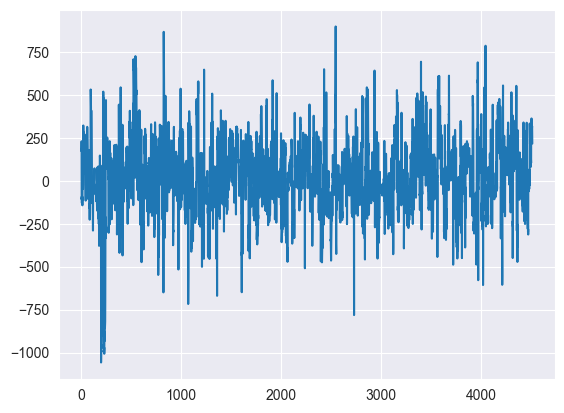

In [21]:
import matplotlib.pyplot as plt

# Generate the time axis
time = np.arange(len(arr))

# Plot the EEG signal
plt.plot(time, arr[:, 0]) #first row
#plt.plot(time, arr) #all rows

#plt.xlabel('')
#plt.ylabel('')
#plt.title('')
plt.show()

---
## II. EEGDenoiseNet Code Comprehension/Notes

### 2.1 Simulated Dataset Generation
#### 2.1.1. Linear Mixing
**Achieved by linearly mixing the pure EEG segments with EOG or EMG artifact segments, according to equation:**

$$y = x + λ · n$$
* $y$ is the simulated data (EEG mixed with artifact)
* $x$ denotes the clean EEG signal
* $n$ denotes the ocular or myogenic artifact
* $λ$ is a hyperparameter to control the signalto-noise ratio (SNR) in the contaminated EEG signal y

*Linear mixing refers to a process in which multiple signals are combined or mixed together in a linear manner. It involves adding or scaling individual signals and summing them to create a composite signal.*


**QUESTIONS**
* **How important is an adjustable SNR in this case? What specific role does SNR play in the dataset and the performance of the denoising algorithm to be used?**
&nbsp; --> Adjusting the SNR allows researchers to control the difficulty of the denoising task. Higher SNR levels (more signal, less noise) represent cleaner and easier-to-denoise signals, while lower SNR levels (weaker signal, more noise) introduce more challenging denoising scenarios. By training the algorithm on a dataset with adjustable SNR, the model can learn to handle both simple and complex denoising tasks, enhancing its generalization and adaptability to real-world EEG data.


* **For my experimentation, how should I deal with the SNR? Should I pick a certain SNR (and how do I pick) or should I use varying SNRs, replicate, and tabulate the results?**
&nbsp; --> Look into related literatures' methods and see which one would work best for your case.


#### 2.1.2. SNR & RMS (Mathematics + Theory)
$$SNR = 10log\frac{RMS(x)}{RMS(λ \times n)}$$

$$RMS(g) = \sqrt{\frac{1}{N}\sum\limits_{i=1}^N g_i^2}$$

## III. Related Literatures' Methods

| Authors + Year           | Title | Objective | Dataset | Methods |
|--------------------------|---------------------|-----------|---------|---------|
| Haoming Zhang et al 2021 | EEGdenoiseNet: a benchmark dataset for deep learning solutions of EEG denoising | Test dataset on different denoising methods (EMD, Filter, FCNN, Simple CNN, Complex CNN, RNN) | TBDTBDTBDTBDTBDTBDTBDTBDTBD | TBDTBDTBDTBDTBDTBDTBDTBDTBDTBD |